<a href="https://colab.research.google.com/github/Waqas70011/Basic-Image-Classification-with-TensorFlow/blob/master/Tomato_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Install Kaggle API if not already installed
!pip install -q kaggle

# 2. Upload kaggle.json (from your Kaggle account settings → API → Create new token)
from google.colab import files
files.upload()

# 3. Move kaggle.json to ~/.kaggle and set permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. Download dataset
!kaggle datasets download -d arjuntejaswi/plant-village -p ./data

# 5. Extract only tomato categories

import zipfile
import os

zip_path = "./data/plant-village.zip"
extract_path = "./tomato_data"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if "Tomato" in file:  # Case-sensitive match, adjust if needed
            zip_ref.extract(file, extract_path)

print("Only tomato files extracted.")


# 6. Verify file counts
for root, dirs, files in os.walk("./tomato_data"):
    print(f"{root}: {len(files)} files")


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/arjuntejaswi/plant-village
License(s): unknown
 95% 313M/329M [00:05<00:00, 44.1MB/s]
100% 329M/329M [00:05<00:00, 61.7MB/s]
Only tomato files extracted.
./tomato_data: 0 files
./tomato_data/PlantVillage: 0 files
./tomato_data/PlantVillage/Tomato_Early_blight: 1000 files
./tomato_data/PlantVillage/Tomato__Target_Spot: 1404 files
./tomato_data/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus: 3209 files
./tomato_data/PlantVillage/Tomato_healthy: 1591 files
./tomato_data/PlantVillage/Tomato_Septoria_leaf_spot: 1771 files
./tomato_data/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite: 1676 files
./tomato_data/PlantVillage/Tomato_Late_blight: 1909 files
./tomato_data/PlantVillage/Tomato_Bacterial_spot: 2127 files
./tomato_data/PlantVillage/Tomato_Leaf_Mold: 952 files
./tomato_data/PlantVillage/Tomato__Tomato_mosaic_virus: 373 files


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

In [3]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./tomato_data/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [5]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
len(dataset)

501

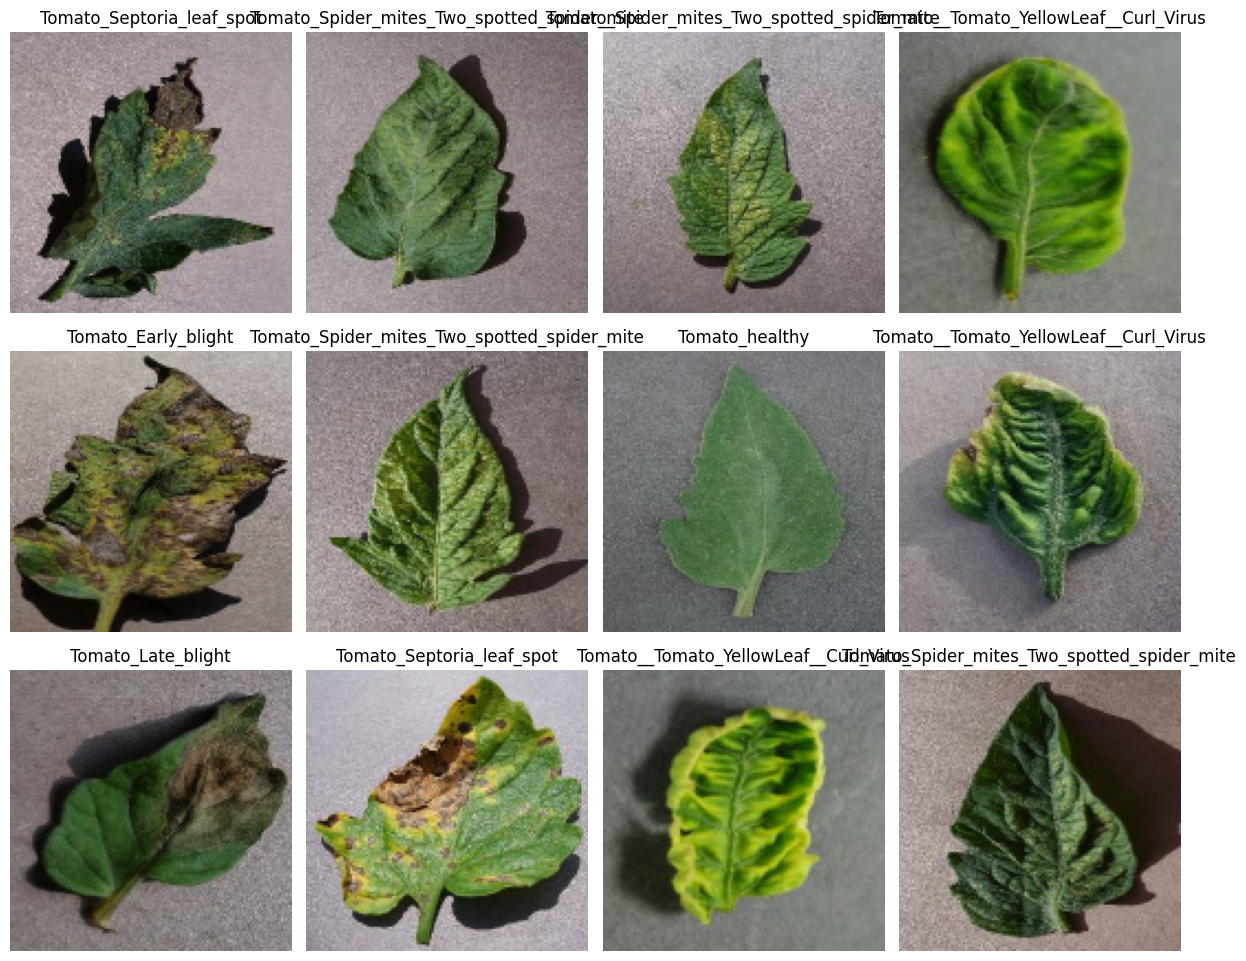

In [7]:
plt.figure(figsize=(12, 12))
for image_batch, label_batch in dataset.take(2):
  #print(image_batch[0])
  #print(label_batch.numpy())
  for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')
    plt.tight_layout()

In [8]:
len(dataset)

501

80% ==> training

20% ==> 10% validation, 10% test

In [9]:
# splitting
train_ds = dataset.take(54)
test_ds = dataset.skip(54)
val_ds = test_ds.take(6)
test_ds = test_ds.skip(6)


In [10]:
test_ds = dataset.skip(54)
len(test_ds)

val_size = 0.1
len(dataset)*val_size

val_ds = test_ds.take(6)
len(val_ds)

test_ds = test_ds.skip(6)
len(test_ds)

441

In [11]:
# writing a function for splitting the dataset in to train, test, val
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle = True, shuffle_size=10000):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split*ds_size)
  val_size = int(val_split*ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size )

  return train_ds, val_ds, test_ds


In [12]:
# Splitting the data into train, test, val
train_ds, tes_ds, val_ds = get_dataset_partitions_tf(dataset)

In [13]:
# Displaying the length of each part of the dataset

print('Train: ',len(train_ds))
print('Test:  ', len(test_ds))
print('Val:   ', len(val_ds))

Train:  400
Test:   441
Val:    51


In [14]:
# read
train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [21]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, (3,3), activation='relu', padding="same", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', padding="same"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', padding="same"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', padding="same"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', padding="same"),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


# No need to call model.build() if you specify input_shape in first Conv2D
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 393,034 (1.50 MB)

 Trainable params: 393,034 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# n_classes = 10

# model = models.Sequential([
#     resize_and_rescale,
#     layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax'),
# ])

# # No need to call model.build() if you specify input_shape in first Conv2D
# model.summary()


In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [23]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - accuracy: 0.2799 - loss: 1.9398 - val_accuracy: 0.5891 - val_loss: 1.2035
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.6881 - loss: 0.9122 - val_accuracy: 0.7482 - val_loss: 0.7403
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.8164 - loss: 0.5317 - val_accuracy: 0.8523 - val_loss: 0.4285
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.8617 - loss: 0.3868 - val_accuracy: 0.9032 - val_loss: 0.2663
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.9024 - loss: 0.2880 - val_accuracy: 0.9210 - val_loss: 0.2417
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9244 - loss: 0.2154 - val_accuracy: 0.9112 - val_loss: 0.2313
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.9347 - loss: 0.1861 - val_accuracy: 0.9148 - val_loss: 0.2217
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.9385 - loss: 0.1764 - 

In [ ]:
#testing the mode l before deployment
scores = model.evaluate(test_ds)

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
# record of all accuracay of each epoch
history.history['accuracy']

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')

In [ ]:
i = 31
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[i].numpy().astype('uint8')
  first_label = labels_batch[i].numpy()

  print('First iamge to predict')
  plt.imshow(first_image)
  print('Actual label: ', class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print('Predicted label', class_names[np.argmax(batch_prediction[i])])


In [ ]:
i = 10  # pick the 11th image

for images_batch, labels_batch in test_ds.take(1):

    # Pick one image & label from the batch
    first_image = images_batch[i].numpy().astype('uint8')
    first_label = labels_batch[i].numpy()

    # Show the image
    plt.imshow(first_image)
    plt.axis('off')
    plt.title(f"Actual: {class_names[first_label]}")
    plt.show()

    # Predict for the whole batch
    batch_prediction = model.predict(images_batch)

    # Get predicted label for the chosen image
    predicted_label = np.argmax(batch_prediction[i])
    predicted_class_name = class_names[predicted_label]

    print(f"Actual label:    {class_names[first_label]}")
    print(f"Predicted label: {predicted_class_name}")
    print(f"Prediction vector: {batch_prediction[i]}")


In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])), 2)
  return predicted_class, confidence

In [ ]:
# Show 9 images in a 3x3 grid from one batch
for images, labels in test_ds.take(2):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i in range(9):
        ax = axes[i // 3, i % 3]  # select correct subplot position
        ax.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i].numpy()]

        #ax.set_xlabel(f"{predicted_class}\n{confidence}%")
        ax.set_title(f'Actual: {class_names[labels[i].numpy()]} \n Predicted: {predicted_class}, \n Confidence: {confidence:.2f}%')
        ax.axis('off')  # hide axis ticks
    plt.tight_layout()
    plt.show()


In [25]:
model_name = 'tomato_blight_detection'
model.save(f'{model_name}.keras')